Import trick

In [2]:
import sys
sys.path.insert(0, '..')

In [3]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import numpy

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior

# the real world
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astrocut import fits_cut
from astropy.nddata import Cutout2D

import pandas as pd

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

data

In [4]:
ddir = '../data/MAST_2024-07-11T09_26_05.575Z/'
fname = ddir + 'HST/N43CA5020/n43ca5020_mos.fits'

wid = 64

exposure = exposure_from_file(fname, wid)

f170m = np.asarray(pd.read_csv("../data/HST_NICMOS1.F170M.dat", sep=' '))
f095n = np.asarray(pd.read_csv("../data/HST_NICMOS1.F095N.dat", sep=' '))
f145m = np.asarray(pd.read_csv("../data/HST_NICMOS1.F145M.dat", sep=' '))

models

In [5]:
wavels = f095n[::5,0]/1e10
weights = f095n[::5,1]


point = dl.PointSource(
    #wavelengths=wavels,
    spectrum=dl.Spectrum(wavels, weights),
    flux = 5000,
)

binary = dl.BinarySource(
    wavelengths=wavels,
    weights=weights,
    spectrum=dl.Spectrum(wavels, weights),
    mean_flux=3000,
    separation=dlu.arcsec2rad(0.042),
    position_angle=1.8607855,
    contrast = 0.3,
)

oversample = 3

optics = dl.AngularOpticalSystem(
    512,
    2.4,
    [
        dl.CompoundAperture([
            ("main_aperture",HSTMainAperture(transformation=dl.CoordTransform(rotation=np.pi/4),softening=0.1)),
            ("cold_mask",NICMOSColdMask(transformation=dl.CoordTransform(translation=np.asarray((-0.05,-0.05)),rotation=np.pi/4), softening=0.1))
        ],normalise=True),
        dl.AberratedAperture(
            dl.layers.CircularAperture(1.2),
            noll_inds=np.asarray([4,5,6,7,8,9,10,11]),#,12,13,14,15,16,17,18,19,20]),
            coefficients = np.asarray([0,18,19.4,-1.4,-3,3.3,1.7,-12.2])*1e-9#,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])*1e-9
        )
    ],
    wid,
    0.0432,
    oversample
)

detector = dl.LayeredDetector(
    [
        ("detector_response", ApplyNonlinearity(coefficients=np.zeros(1), order = 3)),
        ("constant", dl.layers.AddConstant(value=0.0)),
        ("pixel_response",dl.layers.ApplyPixelResponse(np.ones((wid*oversample,wid*oversample)))),
        #("jitter", dl.layers.ApplyJitter(sigma=0.1)),
        ("downsample", dl.layers.Downsample(oversample))
     ]
)


point_model = dl.Telescope(
    optics,
    point,
    detector
)

binary_model = dl.Telescope(
    optics,
    binary,
    detector
)

optimisers

In [6]:

# need a better name for this

def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]

g = 5e-3

things_single = {
    "flux" : opt(g*10,10),
    "position": opt(g*1, 0),
    "cold_mask.transformation.translation": opt(g*10,100),
    "cold_mask.transformation.rotation": opt(g*10,100),
    "AberratedAperture.coefficients": opt(g*1,50),
    "cold_mask.outer.radius": opt(g*10, 130),
    "cold_mask.secondary.radius": opt(g*10,130),
    "cold_mask.spider.width": opt(g*10,130),
}

g = 2e-2

things_binary = {
    "mean_flux" : opt(g*10,10),
    "position": opt(g*1, 0),
    "separation": opt(g*1, 20),
    "contrast": opt(g*1, 20),
    "position_angle": opt(g*1, 20),
    "cold_mask.transformation.translation": opt(g*100,100),
    "cold_mask.transformation.rotation": opt(g*100,100),
    "AberratedAperture.coefficients": opt(g*1,50),
    "cold_mask.outer.radius": opt(g*10, 130),
    "cold_mask.secondary.radius": opt(g*10,130),
    "cold_mask.spider.width": opt(g*10,130),
}

groups_s = list(things_single.keys())
paths_s = flatten(groups_s)
optimisers_s = [things_single[i] for i in groups_s]
groups_s = [list(x) if isinstance(x, tuple) else x for x in groups_s]

groups_b = list(things_binary.keys())
paths_b = flatten(groups_b)
optimisers_b = [things_binary[i] for i in groups_b]
groups_b = [list(x) if isinstance(x, tuple) else x for x in groups_b]

In [7]:
@zdx.filter_jit
@zdx.filter_value_and_grad(paths_s)
def loss_fn_s(model,exposure):
    return posterior(model,exposure)

@zdx.filter_jit
@zdx.filter_value_and_grad(paths_b)
def loss_fn_b(model,exposure):
    return posterior(model,exposure)

In [8]:
rc = False

array_model_s = zdx.set_array(point_model,paths_s)

fishers_s = calc_fishers(array_model_s, [exposure], paths_s, recalculate=rc)
lrs_s = calc_lrs(array_model_s, [exposure], fishers_s, paths_s)

array_model_b = zdx.set_array(binary_model,paths_b)

fishers_b = calc_fishers(array_model_b, [exposure], paths_b, recalculate=rc)
lrs_b = calc_lrs(array_model_b, [exposure], fishers_b, paths_b)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[8.365782]]
[[ 3.5351208e+21 -9.5525359e+19]
 [-9.5525394e+19  3.6985635e+21]]
[[-4.4228264e+11  3.3305222e+11]
 [ 3.3305225e+11 -4.2993051e+11]]
[[-4.504109e+11]]
[[-9.7658616e+20  3.3583353e+20  7.3990504e+20  1.3470008e+21
   2.1993640e+20 -4.3070886e+20  2.0220341e+20 -1.8461974e+20]
 [ 3.3582516e+20 -1.2018227e+21  5.1659029e+20  7.9259673e+20
   3.7709459e+20  4.9874568e+18 -7.9871332e+20  1.9030796e+20]
 [ 7.3992369e+20  5.1659736e+20 -1.3359731e+21 -8.3665087e+20
   2.2262389e+20  9.4224487e+20 -3.3013444e+20  3.4574732e+20]
 [ 1.3470067e+21  7.9259293e+20 -8.3665812e+20  6.8439430e+20
  -2.6026220e+20  7.0690400e+20  3.9060465e+20  6.4592547e+20]
 [ 2.1993728e+20  3.7708946e+20  2.2262479e+20 -2.6026332e+20
   1.2741263e+21  2.4423038e+19 -1.8936247e+20 -1.3772740e+19]
 [-4.3071224e+20  4.9896387e+18  9.4225648e+20  7.0691434e+20
   2.4424026e+19  8.8977639e+20 -2.1934207e+20 -2.5990930e+20]
 [ 2.0220381e+20 -7.9872015e+20 -3.3013412e+20  3.9060666e+20
  -1.8936563e+20 -2.193

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[[29.25996]]
[[ 3.5351208e+21 -9.5525359e+19]
 [-9.5525394e+19  3.6985635e+21]]
[[7.889305e+20]]
[[52496528.]]
[[19638926.]]
[[-4.4228264e+11  3.3305222e+11]
 [ 3.3305225e+11 -4.2993051e+11]]
[[-4.504109e+11]]
[[-9.7658616e+20  3.3583353e+20  7.3990504e+20  1.3470008e+21
   2.1993640e+20 -4.3070886e+20  2.0220341e+20 -1.8461974e+20]
 [ 3.3582516e+20 -1.2018227e+21  5.1659029e+20  7.9259673e+20
   3.7709459e+20  4.9874568e+18 -7.9871332e+20  1.9030796e+20]
 [ 7.3992369e+20  5.1659736e+20 -1.3359731e+21 -8.3665087e+20
   2.2262389e+20  9.4224487e+20 -3.3013444e+20  3.4574732e+20]
 [ 1.3470067e+21  7.9259293e+20 -8.3665812e+20  6.8439430e+20
  -2.6026220e+20  7.0690400e+20  3.9060465e+20  6.4592547e+20]
 [ 2.1993728e+20  3.7708946e+20  2.2262479e+20 -2.6026332e+20
   1.2741263e+21  2.4423038e+19 -1.8936247e+20 -1.3772740e+19]
 [-4.3071224e+20  4.9896387e+18  9.4225648e+20  7.0691434e+20
   2.4424026e+19  8.8977639e+20 -2.1934207e+20 -2.5990930e+20]
 [ 2.0220381e+20 -7.9872015e+20 -3.30134

In [9]:
optim_s, opt_state_s = zdx.get_optimiser(
    point_model, groups_s, optimisers_s
)


losses_s, models_s = [], []
for i in tqdm(range(200)):
    loss, grads = loss_fn_s(point_model,exposure)
    grads = jtu.tree_map(lambda x, y: x * np.abs(y), grads, lrs_s)
    updates, opt_state_s = optim_s.update(grads, opt_state_s)
    point_model = zdx.apply_updates(point_model, updates)

    models_s.append(point_model)
    losses_s.append(loss)

optim_b, opt_state_b = zdx.get_optimiser(
    binary_model, groups_b, optimisers_b
)


losses_b, models_b = [], []
for i in tqdm(range(200)):
    loss, grads = loss_fn_b(binary_model,exposure)
    grads = jtu.tree_map(lambda x, y: x * np.abs(y), grads, lrs_b)
    updates, opt_state_b = optim_b.update(grads, opt_state_b)
    binary_model = zdx.apply_updates(binary_model, updates)

    models_b.append(binary_model)
    losses_b.append(loss)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [10]:
print(losses_s[0], losses_s[-1])
print(losses_b[0], losses_b[-1])


30479764.0 1123369.0
18444820.0 504357.84


In [11]:
for g in groups_s:
    if type(g) == list:
        for s in g:
            print(s, point_model.get(s))
    else:
        print(g, point_model.get(g))

print()

for g in groups_b:
    if type(g) == list:
        for s in g:
            print(s, binary_model.get(s))
    else:
        print(g, binary_model.get(g))

flux 6244.8584
position [-6.0789034e-08  8.9496460e-08]
cold_mask.transformation.translation [-0.05005027 -0.05000168]
cold_mask.transformation.rotation 0.78543735
AberratedAperture.coefficients [-2.1536655e-09  4.5507250e-08 -1.3099292e-08 -2.7210096e-08
  9.2349346e-09  1.4598870e-08 -4.0180659e-09 -8.6167816e-11]
cold_mask.outer.radius 1.1457605
cold_mask.secondary.radius 0.4458974
cold_mask.spider.width 0.09247121

mean_flux 3264.8906
position [-4.987858e-09  7.156228e-08]
separation 1.8891694e-07
contrast 0.15340208
position_angle 2.0303543
cold_mask.transformation.translation [-0.04941156 -0.0513094 ]
cold_mask.transformation.rotation 0.7851215
AberratedAperture.coefficients [ 5.04602538e-09  4.34599450e-08  3.26253069e-09 -3.94063946e-08
  1.50893626e-08  1.43775196e-08 -2.01402139e-09 -1.26574555e-08]
cold_mask.outer.radius 1.1451335
cold_mask.secondary.radius 0.4450444
cold_mask.spider.width 0.0924


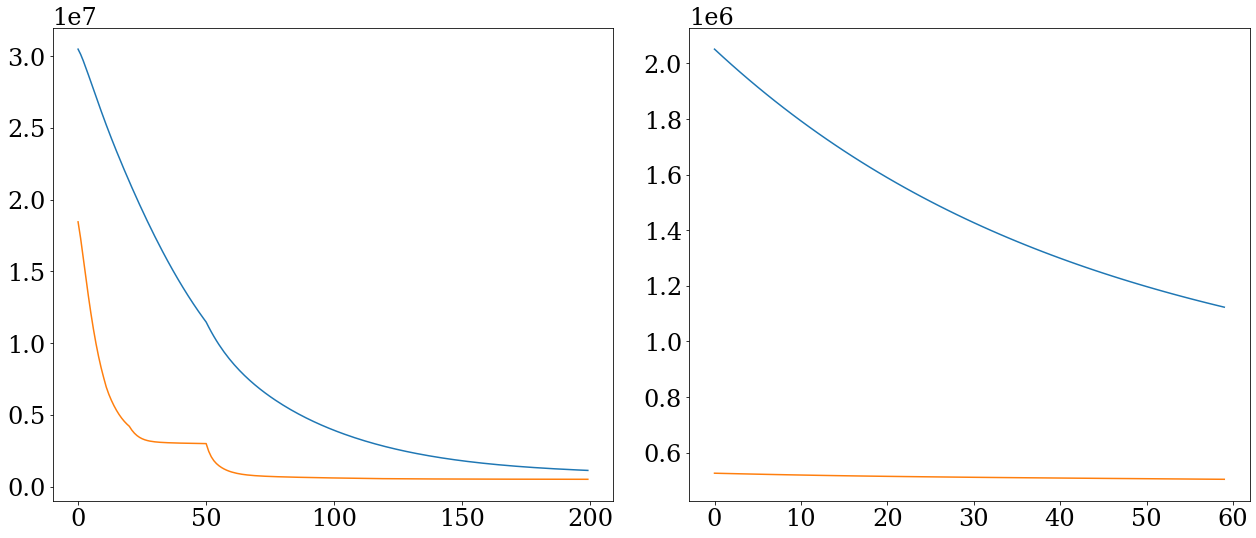

In [12]:
fig, axs = plt.subplots(1,2, figsize=(18,8))
axs[0].plot(losses_s)
axs[1].plot(losses_s[-60:])
axs[0].plot(losses_b)
axs[1].plot(losses_b[-60:])
fig.tight_layout()

31.559742 32.55721


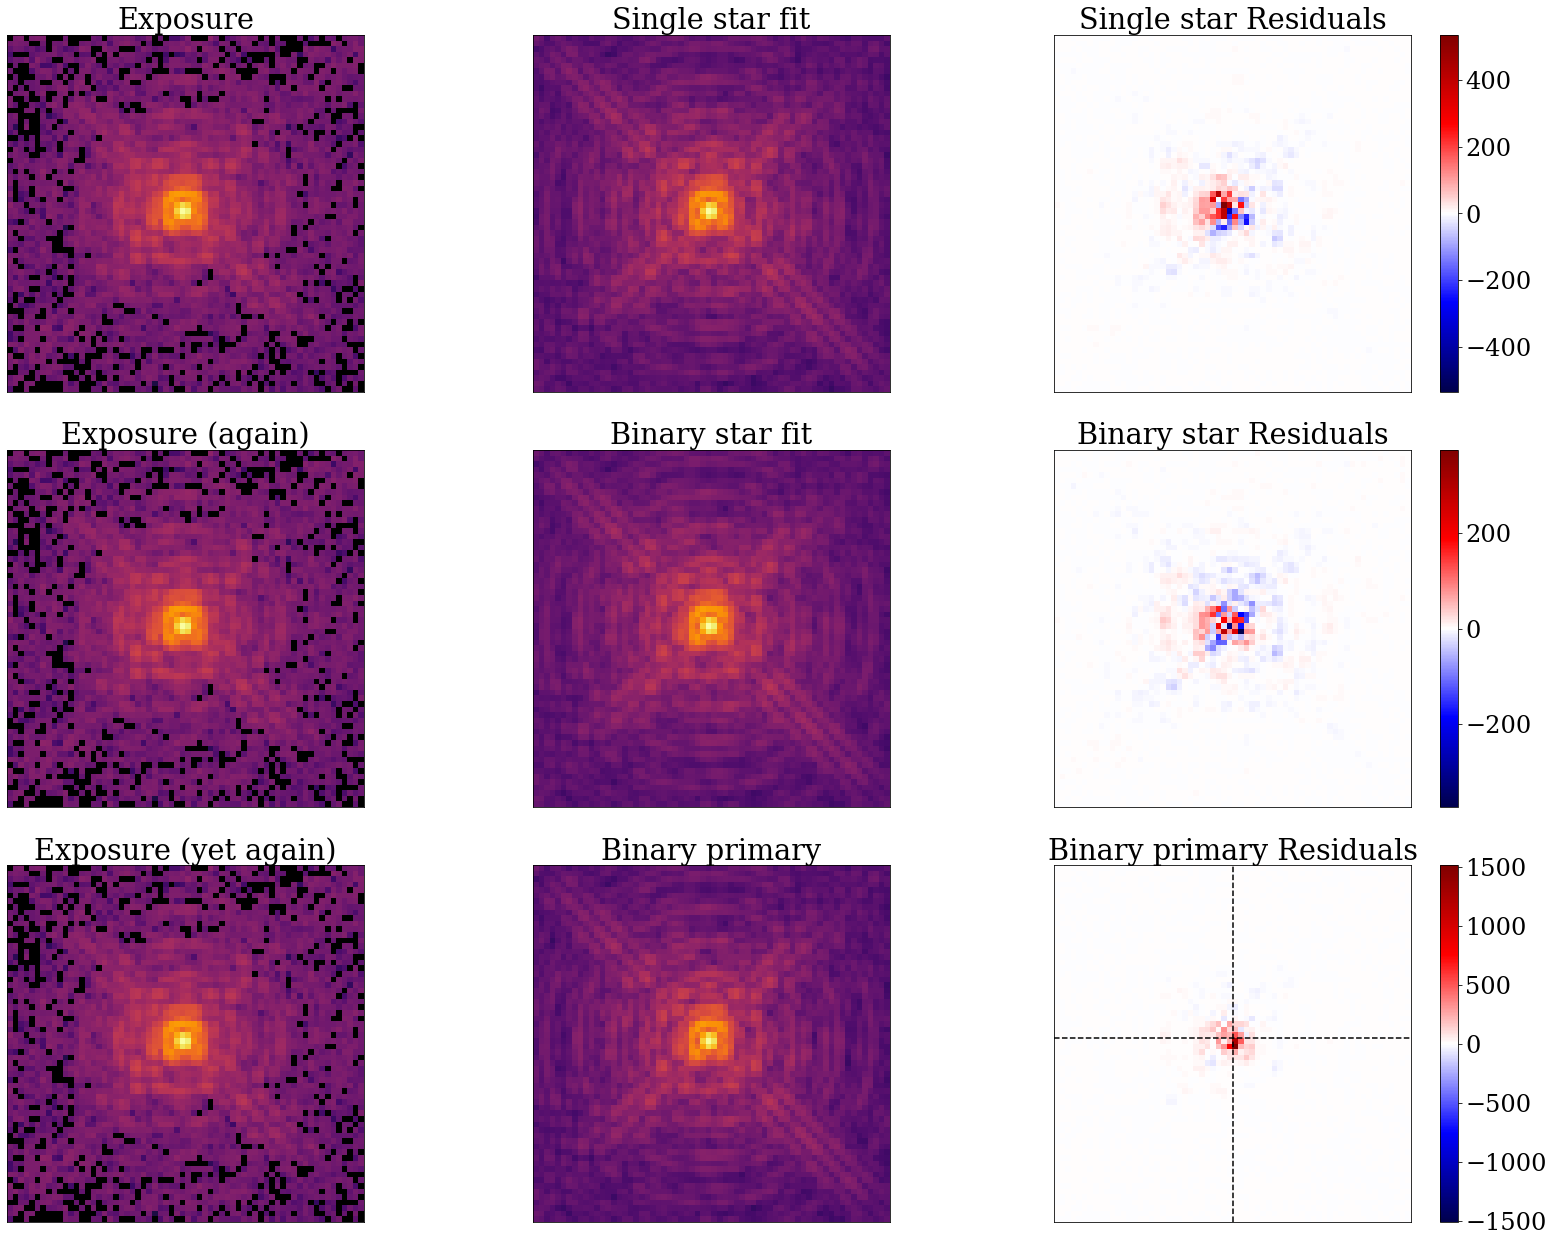

In [32]:
fig, axs = plt.subplots(3,3,figsize=(30*0.8,22*0.8))


cmap = matplotlib.colormaps['inferno']
cmap.set_bad('k',1)

coords = dlu.pixel_coords(512, 2.4)
cropped_frame = exposure.data**0.125

point_frame = point_model.model()**0.125
binary_frame = binary_model.model()**0.125

single_resid = (exposure.data-point_model.model())/exposure.err
binary_resid = (exposure.data-binary_model.model())/exposure.err

vm = max(np.nanmax(cropped_frame),np.nanmax(point_frame), np.nanmax(binary_frame))


axs[0,0].imshow(cropped_frame,cmap=cmap, vmin=0, vmax=vm)
axs[0,1].imshow(point_frame,cmap=cmap, vmin=0, vmax=vm)
rlim = np.nanmax(np.abs(single_resid))
resid = axs[0,2].imshow(single_resid, vmin=-rlim, vmax=rlim, cmap='seismic')
plt.colorbar(resid,ax=axs[0,2])

axs[1,0].imshow(cropped_frame,cmap=cmap, vmin=0, vmax=vm)
axs[1,1].imshow(binary_frame,cmap=cmap, vmin=0, vmax=vm)

rlim = np.nanmax(np.abs(binary_resid))
resid = axs[1,2].imshow(binary_resid, vmin=-rlim, vmax=rlim, cmap='seismic')
plt.colorbar(resid,ax=axs[1,2])

binary_primary_source = dl.PointSource(
    spectrum=dl.Spectrum(wavels,weights),
    position = dlu.positions_from_sep(
        binary_model.position,
        binary_model.separation,
        binary_model.position_angle
    )[1],
    flux = dlu.fluxes_from_contrast(
        binary_model.mean_flux,
        binary_model.contrast
    )[1]
)

binary_primary_system = dl.Telescope(
    binary_model.optics,
    binary_primary_source,
    binary_model.detector
)

binary_primary_frame = binary_primary_system.model()**0.125

axs[2,0].imshow(cropped_frame,cmap=cmap, vmin=0, vmax=vm)
axs[2,1].imshow(binary_primary_frame,cmap=cmap, vmin=0, vmax=vm)

bp_resid = (exposure.data-binary_primary_system.model())/exposure.err
rlim = np.nanmax(np.abs(bp_resid))
resid = axs[2,2].imshow(bp_resid, vmin=-rlim, vmax=rlim, cmap='seismic')
plt.colorbar(resid,ax=axs[2,2])

x, y = dlu.rad2arcsec(binary_primary_system.position)/0.042 + wid/2

print(x,y)

axs[2,2].axvline(x, color='k',linestyle='--')
axs[2,2].axhline(y, color='k',linestyle='--')

axs[0,0].set_title("Exposure")
axs[1,0].set_title("Exposure (again)")
axs[2,0].set_title("Exposure (yet again)")

axs[0,1].set_title("Single star fit")
axs[1,1].set_title("Binary star fit")
axs[2,1].set_title("Binary primary")

axs[0,2].set_title("Single star Residuals")
axs[1,2].set_title("Binary star Residuals")
axs[2,2].set_title("Binary primary Residuals")



for i in range(3):
    for j in range(3):
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])

fig.tight_layout()


8
flux
position
cold_mask.transformation.translation
cold_mask.transformation.rotation
AberratedAperture.coefficients
cold_mask.outer.radius
cold_mask.secondary.radius
cold_mask.spider.width


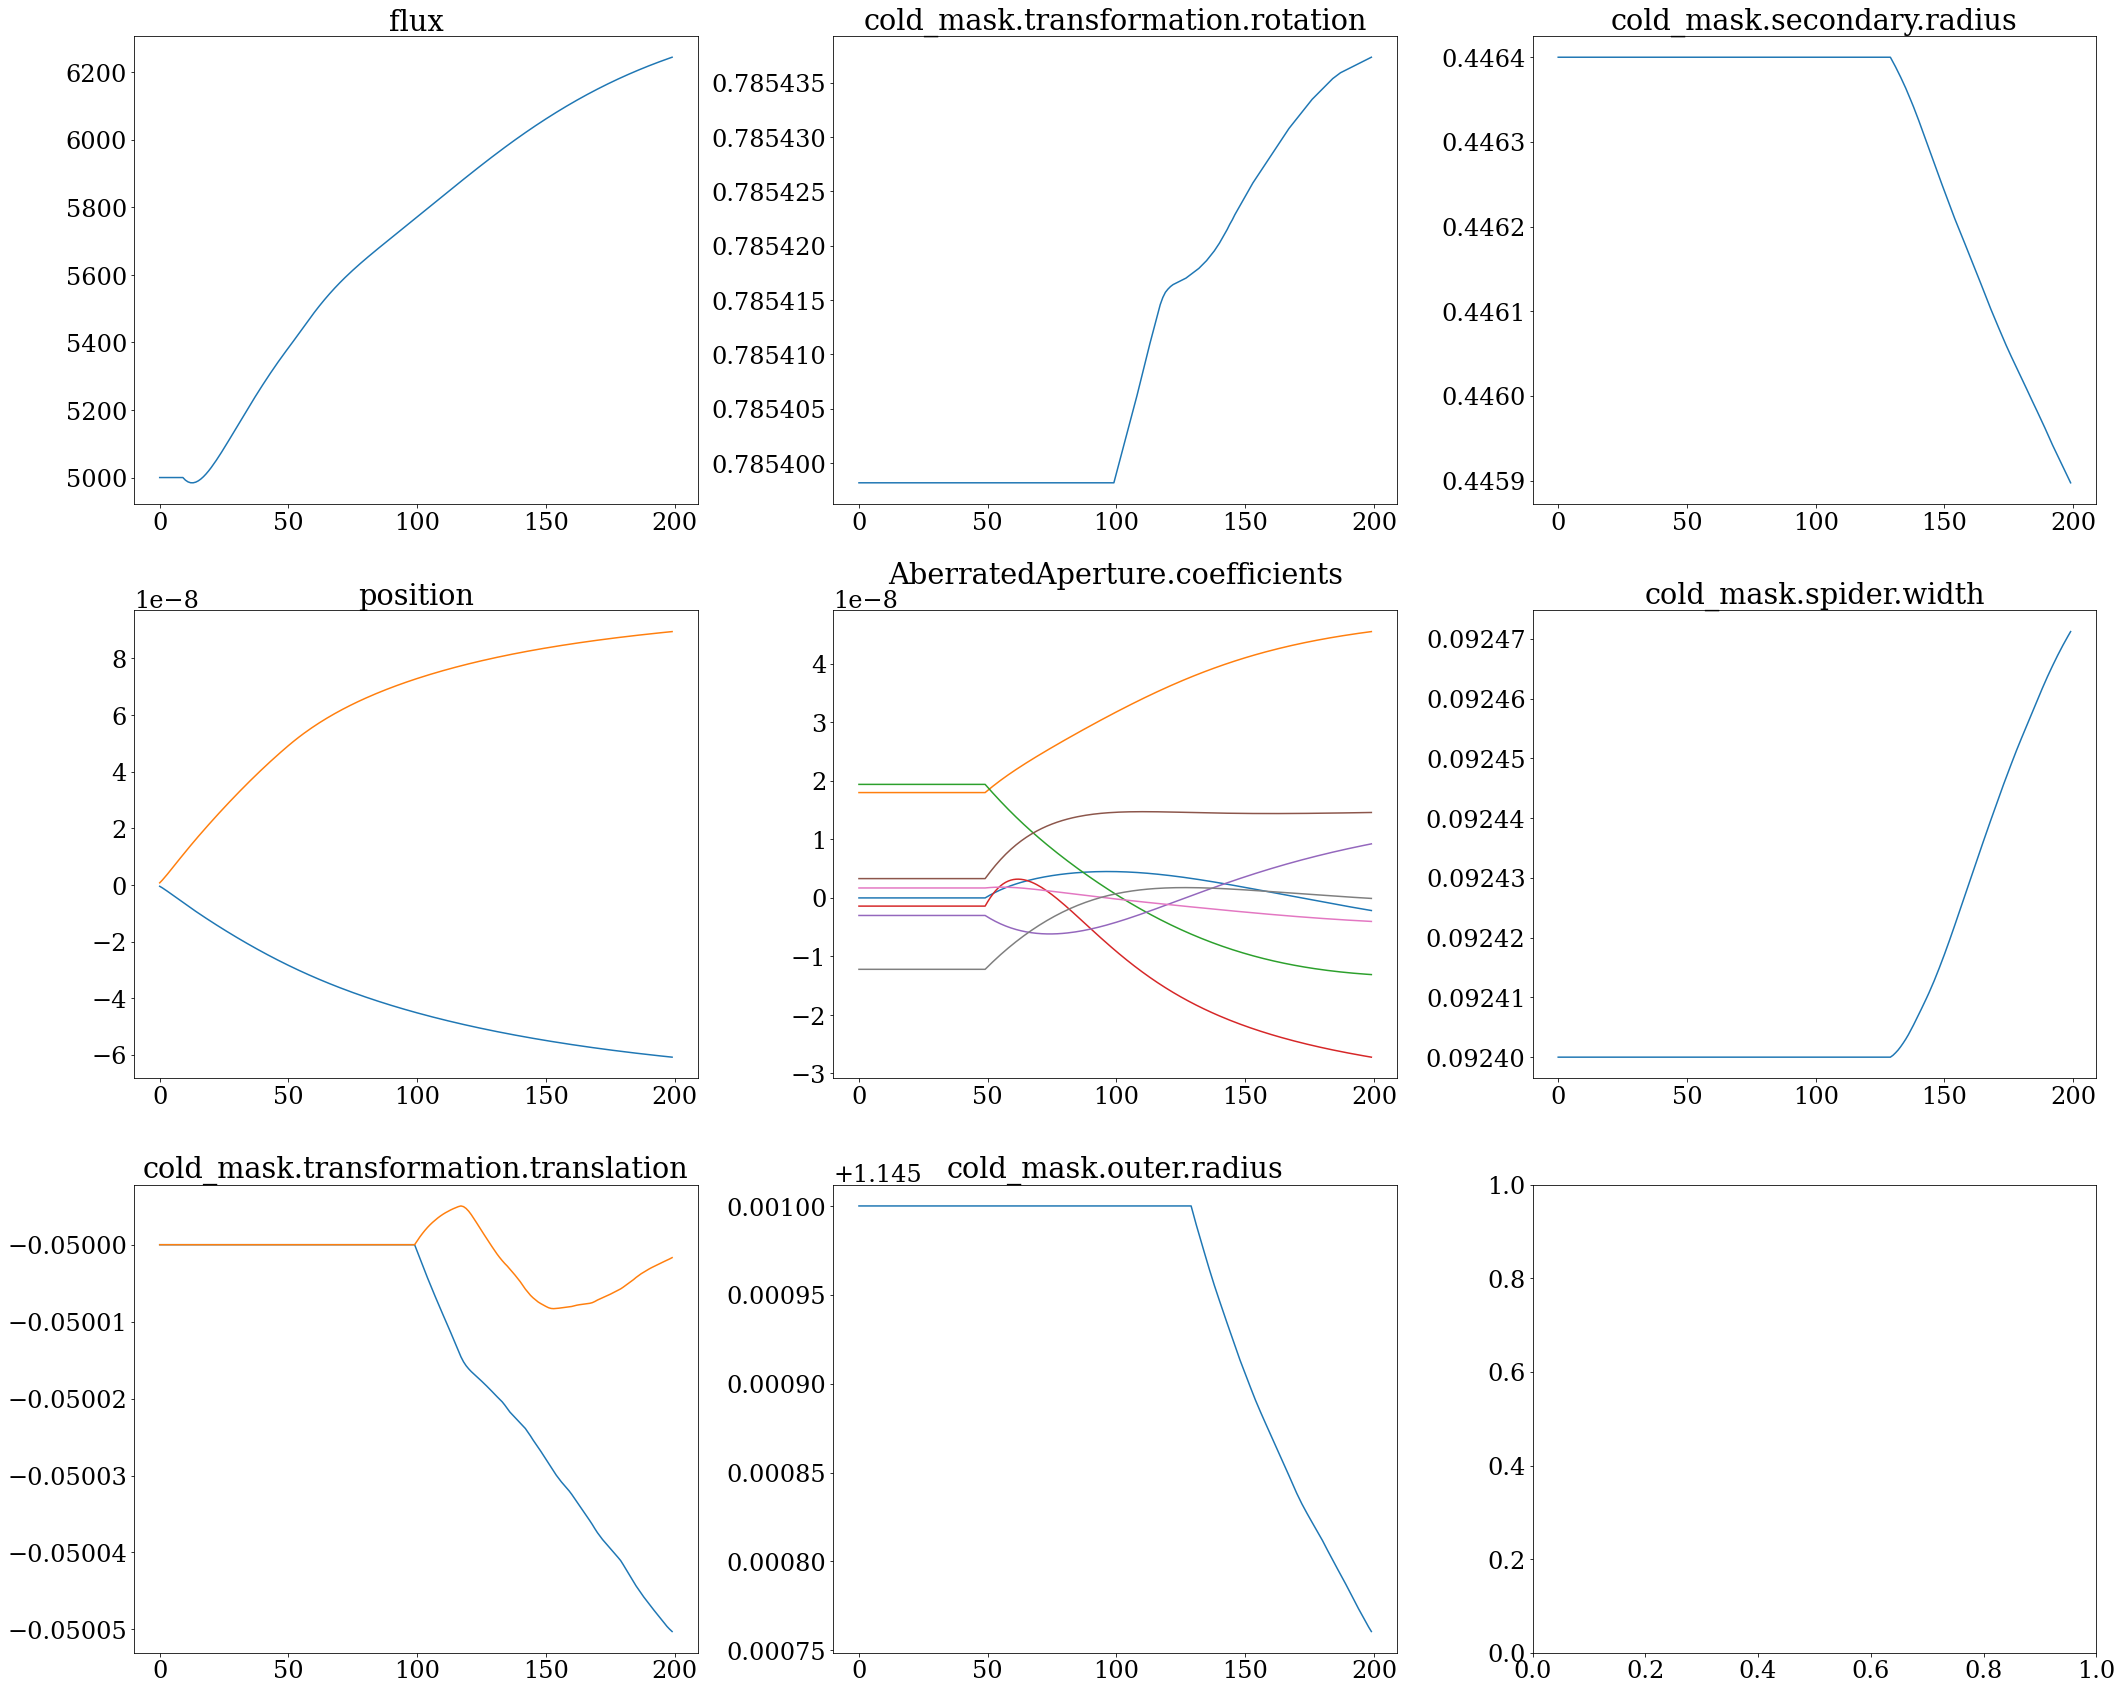

In [14]:
xw = 3
yw = int(np.ceil(len(groups_s)/xw))

print(len(groups_s))

fig, axs = plt.subplots(xw,yw,figsize=(xw*10,yw*8))
for i, param in enumerate(groups_s):
    print(param)
    sp = axs[i%xw, i//xw]
    if type(param) == list:
        sp.set_title(f"{param[0]} ...")
        for p in param:
            sp.plot([x.get(p) for x in models_s])
    else:
        sp.set_title(param)
        sp.plot([x.get(param) for x in models_s])
    
fig.tight_layout()

11
mean_flux
position
separation
contrast
position_angle
cold_mask.transformation.translation
cold_mask.transformation.rotation
AberratedAperture.coefficients
cold_mask.outer.radius
cold_mask.secondary.radius
cold_mask.spider.width


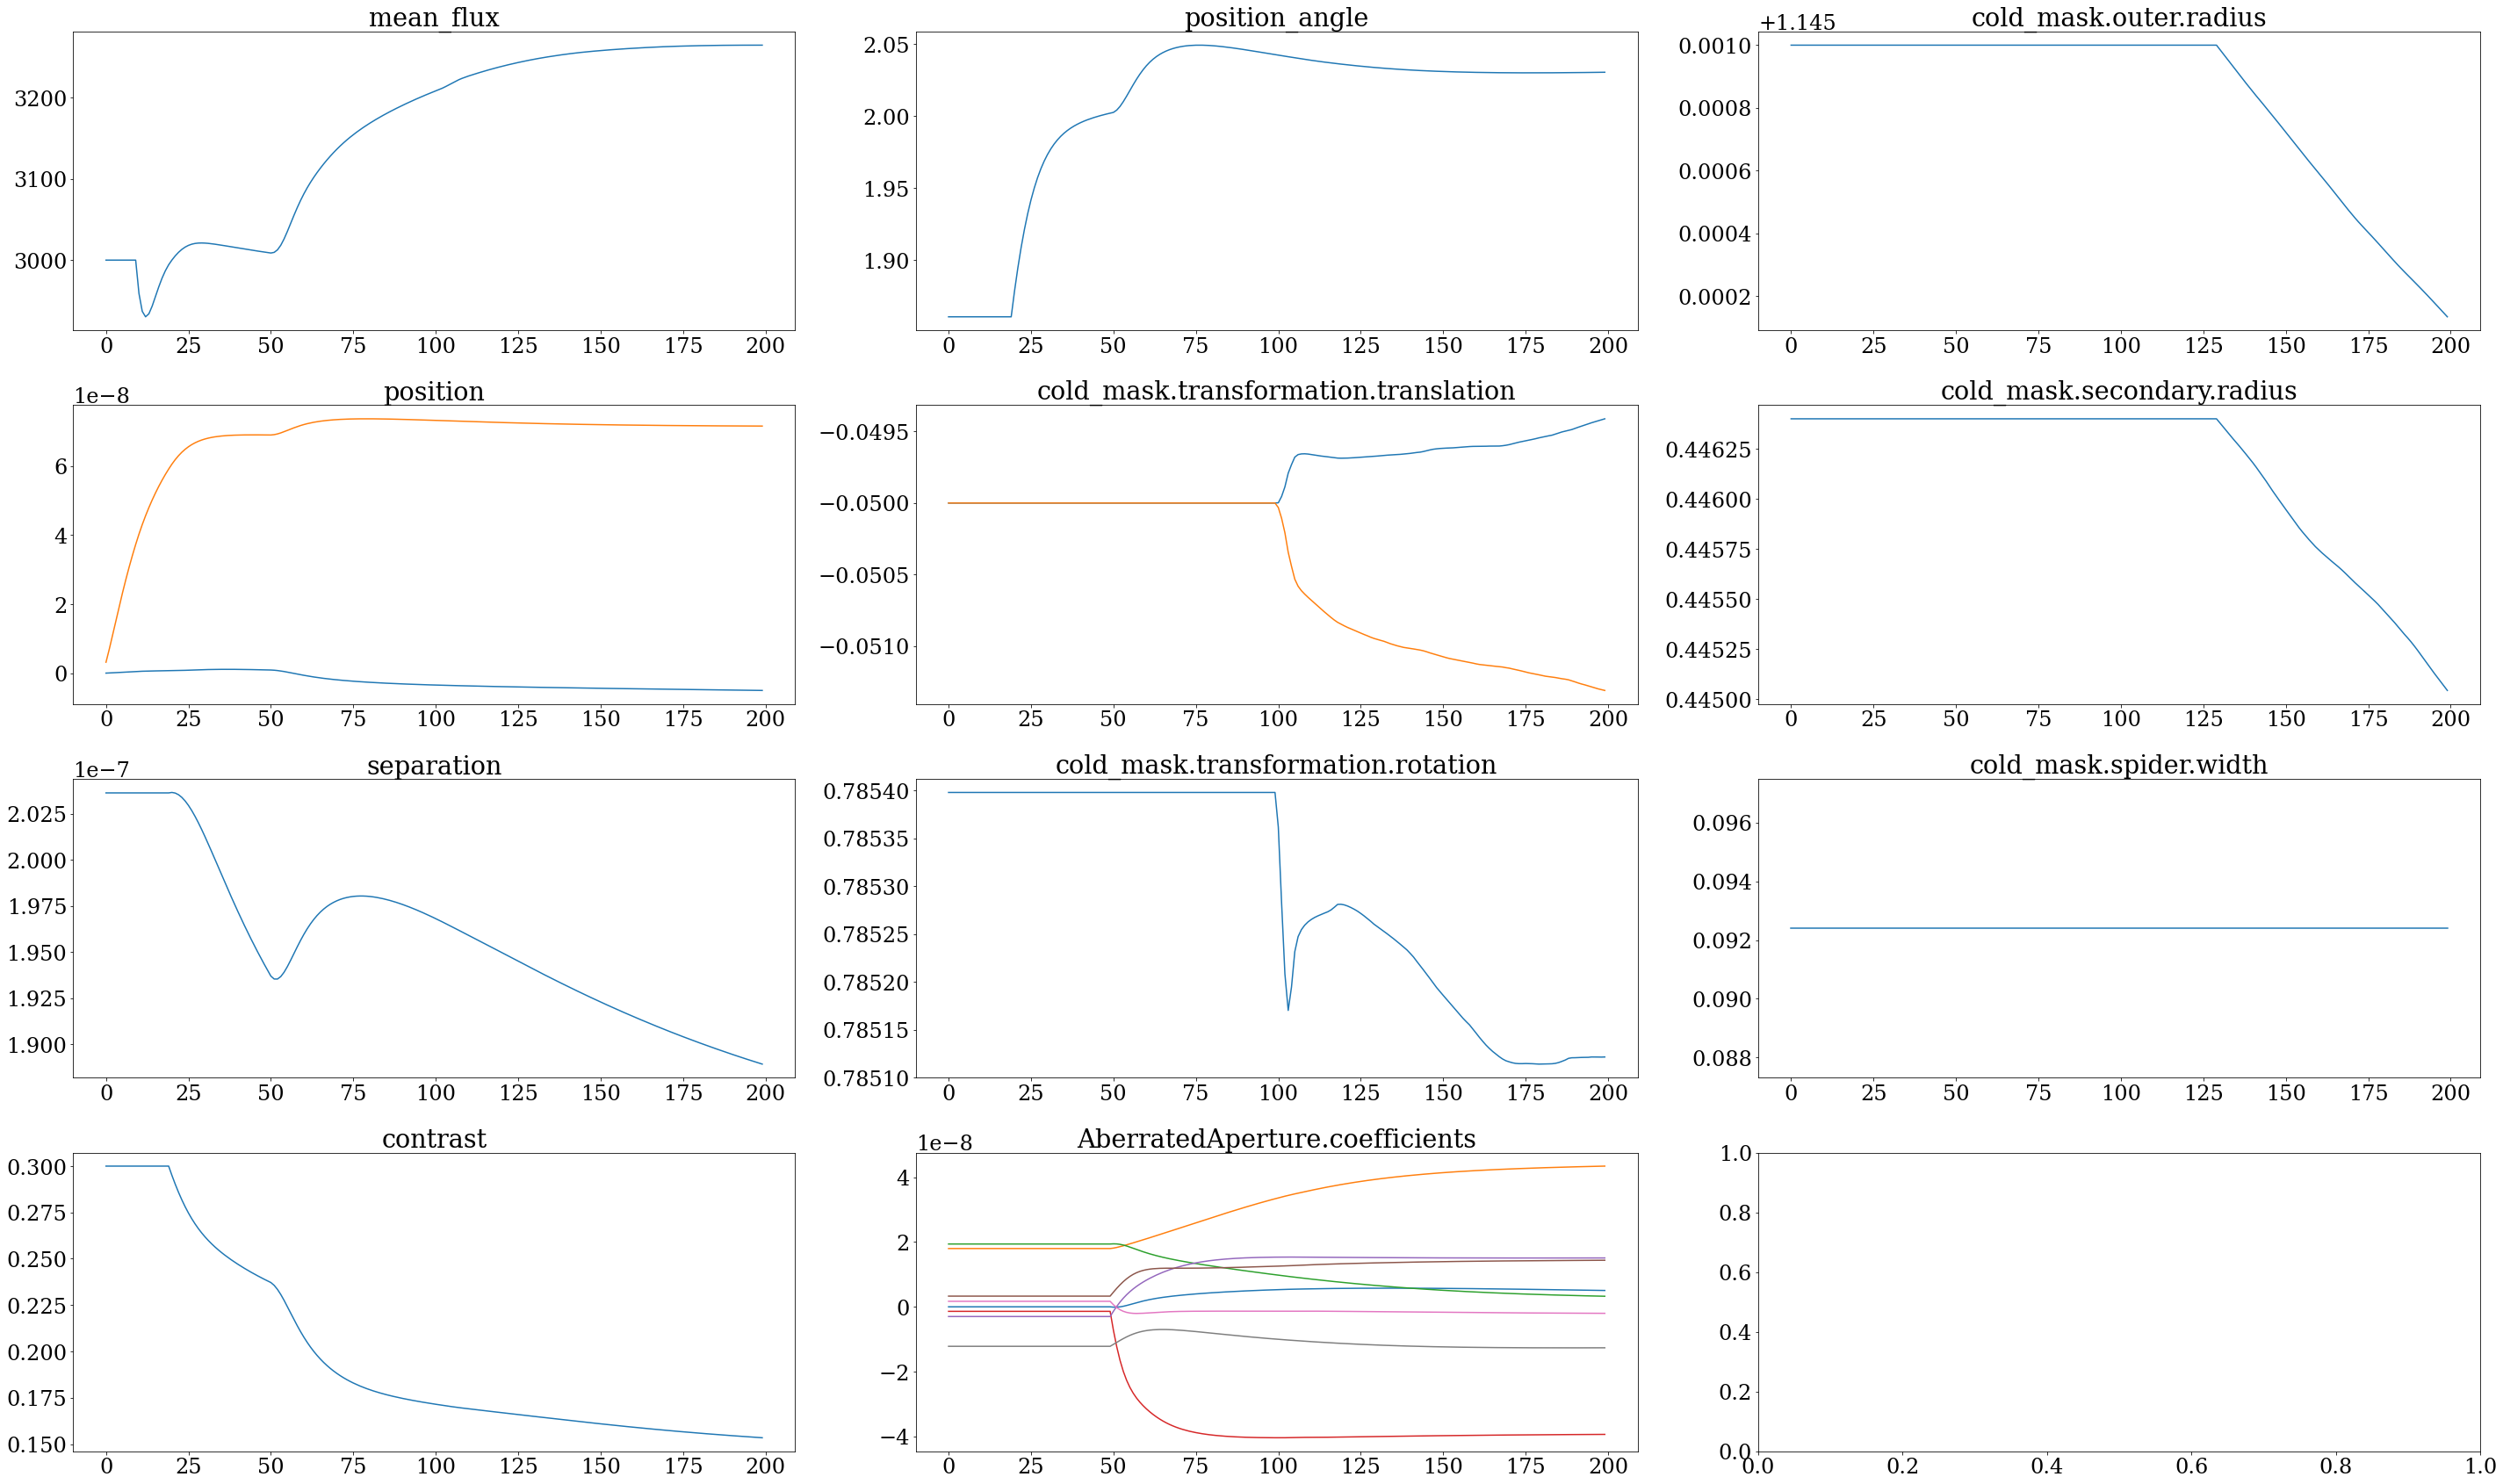

In [15]:
xw = 4
yw = int(np.ceil(len(groups_b)/xw))

print(len(groups_b))

fig, axs = plt.subplots(xw,yw,figsize=(xw*10,yw*8))
for i, param in enumerate(groups_b):
    print(param)
    sp = axs[i%xw, i//xw]
    if type(param) == list:
        sp.set_title(f"{param[0]} ...")
        for p in param:
            sp.plot([x.get(p) for x in models_b])
    else:
        sp.set_title(param)
        sp.plot([x.get(param) for x in models_b])
    
fig.tight_layout()